In [9]:
## Goals of this experiment
## - we can use SGHMCHD as optimizer for BO
## - a non-hacked version of it with a non-tuned standard default stepsize performs comparably well
## - we can get performance benefits over SGHMC with well-tuned initial stepsize??

%matplotlib inline
import sys
import seaborn as sns
from os.path import dirname, join as path_join, isdir
from glob import glob
import json
import pandas as pd

from collections import defaultdict

sys.path.insert(0, path_join("..", "..", ".."))

RESULT_DIR = path_join("..", "..", "..", "cluster_results", "hpolib")


def load_results(directory):
    directories = [
        directory for directory in glob("{}/*".format(directory))
        if isdir(directory)
    ]
    
    def load_json(filename):
        with open(filename) as f:
            return json.load(f)
    
    configurations = tuple(
        load_json(path_join(directory, "config.json"))
        for directory in directories
        if "_sources" not in directory
    )
    
    results = tuple(
        load_json(path_join(directory, "run.json"))
        for directory in directories
        if "_sources" not in directory
    )
    
    
    runs = defaultdict(lambda: defaultdict(list))
    
    print("{} Configurations, {} results".format(len(configurations), len(results)))
    for configuration, result in zip(configurations, results):
        if result["status"] == "COMPLETED":
            runs[configuration["benchmark"]][configuration["method"]].append(result)
    
    
    return runs

def rename(name):
    mappings = {
        "gp": "GP", "gp_mcmc": "GP_MCMC", "RF": "RF",
        "bohamiann": "BOHAMIANN",
        "keras_bohamiann": "BOHAMIANN_TF",
        "random_search": "Random Search",
        "entropy_search": "Entropy Search"
    }
    titles = {
        name: name.title() 
        for name in (
            "bohachevsky", "branin",
            "hartmann3", "hartmann6"
        )
    }
    return mappings.get(name) or titles.get(name) or name

runs = load_results(RESULT_DIR)
BENCHMARKS = sorted(runs.keys())

def results_on(benchmark):
    timepoints = []
    methods = []
    repetitions = []
    regrets = []
    
    for method, method_runs in runs[benchmark].items():
        for repetition, run in enumerate(method_runs):
            if repetition > 30:
                continue
            for timepoint, regret in enumerate(run["result"]["regret"]):
                methods.append(rename(method))
                repetitions.append(repetition)
                timepoints.append(float(timepoint))
                regrets.append(regret)
    return pd.DataFrame(data={
        "Number of function evaluations": timepoints,
        "Method": methods,
        "repetition": repetitions,
        "Immediate Regret": regrets
    }).sort_values(by=["Method"])


2240 Configurations, 2240 results


/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


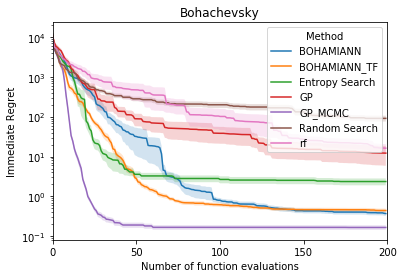

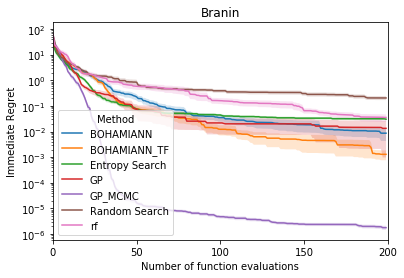

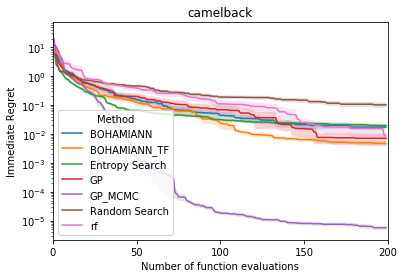

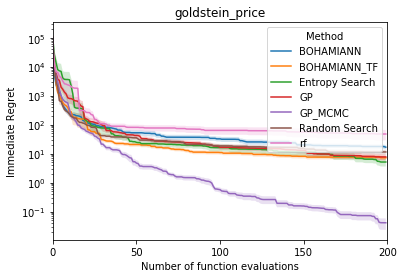

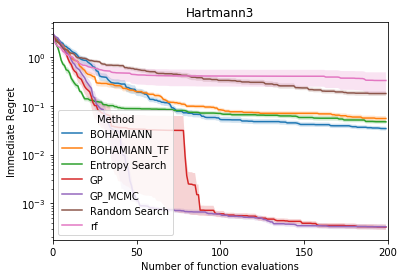

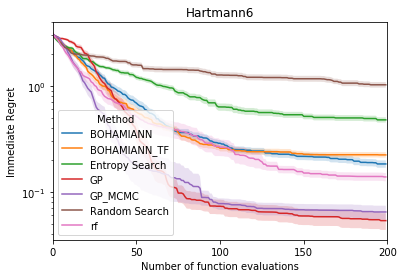

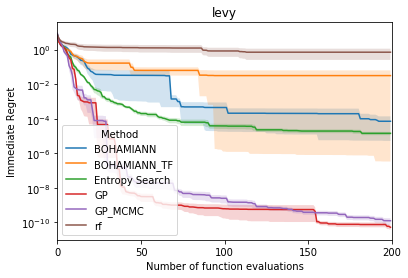

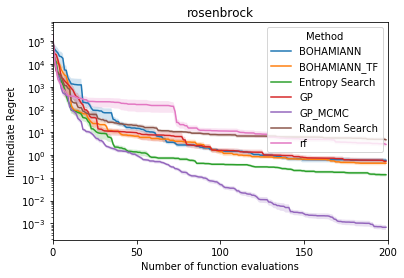

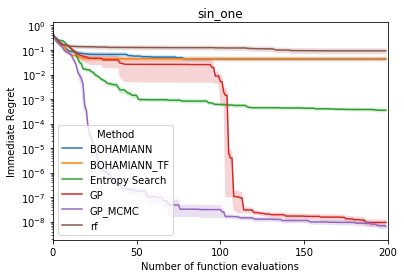

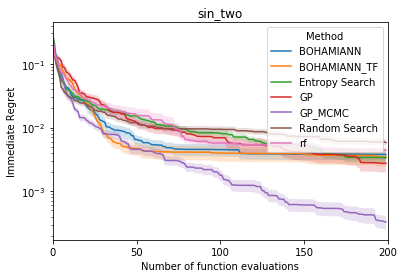

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

for benchmark in BENCHMARKS:
    ax = sns.tsplot(
        time="Number of function evaluations", 
        value="Immediate Regret",
        unit="repetition", condition="Method",
        data=results_on(benchmark)
    )
    ax.set_title(rename(benchmark))
    ax.set_xticks([0, 50, 100, 150, 200])
    ax.set_yscale("log")
    plt.savefig(path_join(RESULT_DIR, "{benchmark}.svg".format(benchmark=benchmark)), format="svg")
    plt.show()
